# Adding MONAI to PyTorch cifar10 classification

This notebook will show the flexibility of MONAI by taking a very simple PyTorch example and enhancing it with MONAI. The example we will begin with is classification on CIFAR10 dataset (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). This notebook is broken into following parts:

1. The original CIFAR-10 classification tutorial.
2. Using MONAI transforms without having to change any code.
3. Easily replacing a NueralNetwork with one provided in MONAI.

## Setup

CIFAR-10 is a classification dataset with 10 classes ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. Each image in CIFAR-10 is 3x32x32.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import monai
from PIL import Image
import numpy as np

%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


Let's setup the dataloader and transform.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let's show some images.

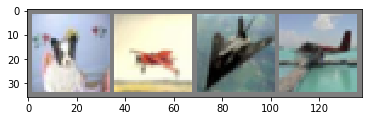

  dog plane plane plane


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Define a Convolution Neural Network

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
# Assume that we are on a CUDA machine, then this should print a CUDA device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net.to(device)

cuda:0


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Let's setup an optimizer

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Let's setup a simple training loop

In [8]:
from time import time

no_epochs = 2

def train(no_epochs, trainloader, optimizer, net, criterion):
    no_iterations = len(trainloader)

    start = time()
    for epoch in range(no_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'Epoch {epoch+1}/{no_epochs}, Iteration {i+1}/{no_iterations}: Loss = {running_loss / 2000}')
                running_loss = 0.0

    print(f'Finished Training in {time()-start} seconds.')
    
train(no_epochs, trainloader, optimizer, net, criterion)

Epoch 1/2, Iteration 2000/12500: Loss = 2.1585227974653245
Epoch 1/2, Iteration 4000/12500: Loss = 1.8301588917076588
Epoch 1/2, Iteration 6000/12500: Loss = 1.673056129336357
Epoch 1/2, Iteration 8000/12500: Loss = 1.5852073608338832
Epoch 1/2, Iteration 10000/12500: Loss = 1.5238751489222049
Epoch 1/2, Iteration 12000/12500: Loss = 1.4723967086076737
Epoch 2/2, Iteration 2000/12500: Loss = 1.403484536588192
Epoch 2/2, Iteration 4000/12500: Loss = 1.3825845147520304
Epoch 2/2, Iteration 6000/12500: Loss = 1.343847774296999
Epoch 2/2, Iteration 8000/12500: Loss = 1.3481838842481375
Epoch 2/2, Iteration 10000/12500: Loss = 1.3130395187735557
Epoch 2/2, Iteration 12000/12500: Loss = 1.2754147632271051
Finished Training in 117.91511368751526 seconds.


Let's see some test images, run the network on them and see results

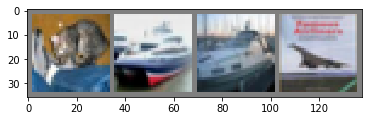

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship  ship


In [14]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Let's look at the accuracy over test set.

In [17]:
print(device)

cuda:0


In [20]:
def get_accuracy(testloader, net, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.cpu()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    
get_accuracy(testloader, net, device)

Accuracy of the network on the 10000 test images: 52 %


## Use transforms from MONAI

Now we will see how easy it is to use parts from MONAI to augment your existing code. Let's begin with using some transforms from MONAI.

First, We will reset the network parameters so we can train it again.

In [65]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()
        
net.apply(weight_reset)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Next, we will write a simple transform called `PILToNumpy` to convert the input from CIFAR-10 dataset to numpy arrays because MONAI transforms work on numpy arrays. Then, we can simple add the `AsChannelFirst`, `RandFlip`, `RandRotate` and `IntensityNormalizer` transforms. 

In [66]:
class PILToNumpy(object):
    def __init__(self):
        pass
    
    def __call__(self, img):
        assert isinstance(img, Image.Image), "input must be a PIL image."

        return np.array(img).astype(np.float32)

transform = transforms.Compose(
                [PILToNumpy(),
                 monai.transforms.AsChannelFirst(),
                 monai.transforms.RandFlip(prob=0.5, spatial_axis=[1, 0]),
                 monai.transforms.RandRotate(prob=0.5, degrees=90),
                 monai.transforms.IntensityNormalizer(np.array((0, 0, 0)), 
                                                      np.array((255, 255, 255))),
                 monai.transforms.GaussianNoise(),
                 monai.transforms.ToTensor(),
                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Let's retrain the network and run it on test set.

In [67]:
train(no_epochs, trainloader, optimizer, net, criterion)

Epoch 1/2, Iteration 2000/12500: Loss = 2.1631794204711916
Epoch 1/2, Iteration 4000/12500: Loss = 1.820360756099224
Epoch 1/2, Iteration 6000/12500: Loss = 1.6927146515846252
Epoch 1/2, Iteration 8000/12500: Loss = 1.5963873181343078
Epoch 1/2, Iteration 10000/12500: Loss = 1.510814044341445
Epoch 1/2, Iteration 12000/12500: Loss = 1.4680281994044782
Epoch 2/2, Iteration 2000/12500: Loss = 1.4026644861251116
Epoch 2/2, Iteration 4000/12500: Loss = 1.3909978227764368
Epoch 2/2, Iteration 6000/12500: Loss = 1.3315526320040225
Epoch 2/2, Iteration 8000/12500: Loss = 1.3111969945579767
Epoch 2/2, Iteration 10000/12500: Loss = 1.3066390281617641
Epoch 2/2, Iteration 12000/12500: Loss = 1.290063578262925
Finished Training in 116.47749829292297 seconds.


In [68]:
get_accuracy(testloader, net, device)

Accuracy of the network on the 10000 test images: 56 %


As we see, our accuracy has improved by a small margin.

## Import Loss from MONAI